# Predicting the chances of Graduate Admission based upon CGPA, GRE scores etc.

<h3>The Problem Statement</h3> 
Predicting the chances of Graduate Admission from Indian Perspective while considering the following factors
<ol>
<li>CGPA (1.00 to 10.00)</li>
<li>GRE Score (out of 340)</li>
<li>TOEFL Score (out of 120)</li>
<li>SOP Strength (1.00 to 5.00)</li>
<li>LOR Strength (1.00 to 5.00)</li>
<li>University Rating (1.00 to 5.00)</li>
<li>Research (0 or 1)</li>
</ol>
The output is the chances of graduate admission ranging from (0.00 to 1.00)

Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
from LocalLinearReg import LocalLinearRegression
from ValidationCurveStore import ValidationCurve
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Reading the dataset and removing the redundant Column 'Serial No.'

In [3]:
dataset = pd.read_csv('./Dataset/Admission_Predict.csv')
pd.options.display.max_columns = None
dataset.drop(['Serial No.'] ,axis = 1,inplace=True)
dataset.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


Checking the dataset for any missing values

In [3]:
dataset.isnull().any()

GRE Score            False
TOEFL Score          False
University Rating    False
SOP                  False
LOR                  False
CGPA                 False
Research             False
Chance of Admit      False
dtype: bool

As seen from above none of the columns do not report missing values. The dataset is complete without the absence of any missing values. Any treatment for missing values is thus not reuqired

In [4]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,400.0,316.807500,11.473646,290.00,308.00,317.00,325.0000,340.00
TOEFL Score,400.0,107.410000,6.069514,92.00,103.00,107.00,112.0000,120.00
University Rating,400.0,3.087500,1.143728,1.00,2.00,3.00,4.0000,5.00
SOP,400.0,3.400000,1.006869,1.00,2.50,3.50,4.0000,5.00
LOR,400.0,3.452500,0.898478,1.00,3.00,3.50,4.0000,5.00
CGPA,400.0,8.598925,0.596317,6.80,8.17,8.61,9.0625,9.92
Research,400.0,0.547500,0.498362,0.00,0.00,1.00,1.0000,1.00
Chance of Admit,400.0,0.724350,0.142609,0.34,0.64,0.73,0.8300,0.97


The dataset and its important statistical measures(column wise) can be seen from above.

Now we plot the box plots of the all the columns to check for any outliers and then decide on the strategies of dealing with the outliers

Text(0.5, 1.0, 'Research')

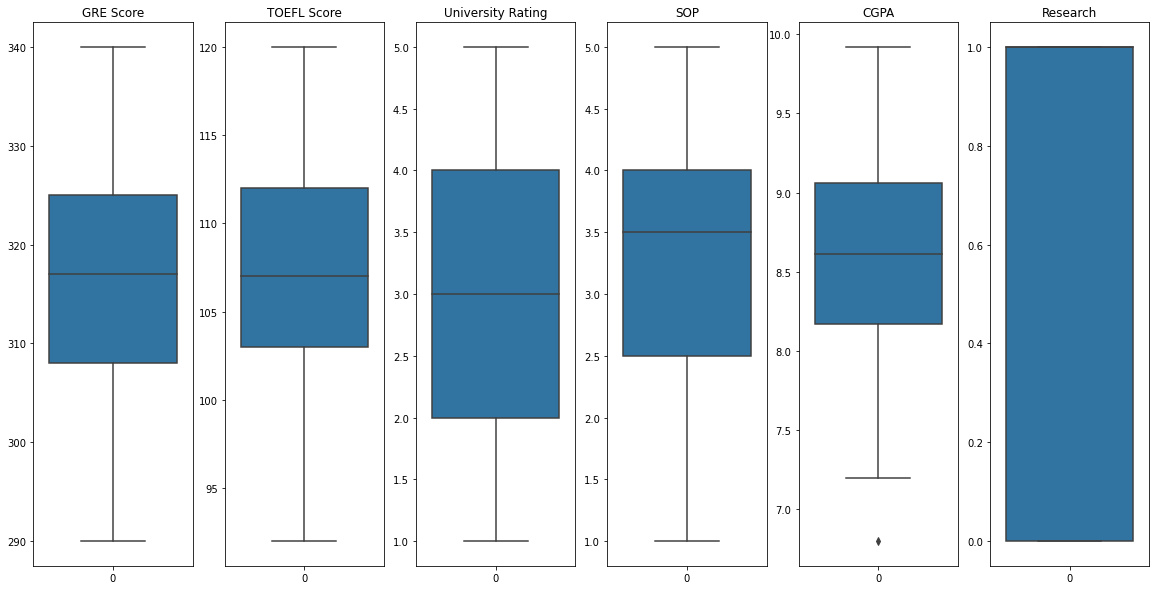

In [5]:
f, ax = plt.subplots(1,6,figsize = (20,10))
sns.boxplot(data = dataset['GRE Score'],ax = ax[0]).set_title('GRE Score')
sns.boxplot(data = dataset['TOEFL Score'],ax = ax[1]).set_title('TOEFL Score')
sns.boxplot(data = dataset['University Rating'],ax = ax[2]).set_title('University Rating')
sns.boxplot(data = dataset['SOP'], ax = ax[3]).set_title('SOP')
sns.boxplot(data = dataset['CGPA'],ax = ax[4]).set_title('CGPA')
sns.boxplot(data = dataset['Research'],ax = ax[5]).set_title('Research')

The boxplots show that all the columns except the CGPA have no outliers at all. The CGPA too has only one outlier. Thus no treatment for outliers is required in this dataset. Overall the dataset is complete and without much noise.

The next step is to plot the correlation matrix to check for interdependency of the features as well as the relation of features with the target variable.

<AxesSubplot:>

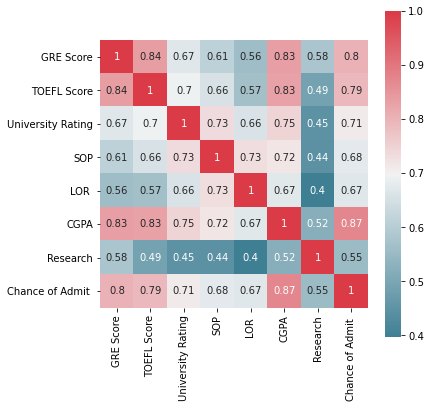

In [6]:
f, ax = plt.subplots(figsize=(6,6))
corr = dataset.corr()
sns.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap = sns.diverging_palette(220,10,as_cmap=True),square = True,ax=ax,annot=True)

<ol>
<li>The GRE Score is highly correlated to TOEFL Score(0.87) and CGPA(0.83)</li>
<li>The TOEFL score is highly correlated to CGPA(0.83)</li>
<li>The Chance of Admit is stronlgy correlated to GRE Scores(0.8), TOEFL Scores(0.79) and CGPA(0.87)</li>
</ol>

<h2>Exploratory Data Analysis</h2>

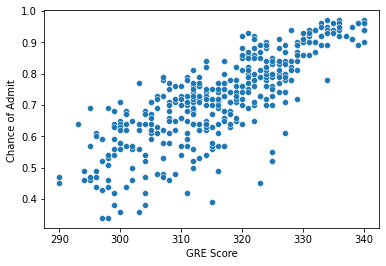

In [45]:
# For GRE Scores
sns.scatterplot(x=dataset['GRE Score'], y=dataset['Chance of Admit '])
plt.show()

As the GRE Scores increase the Chances of Admission increase with a slight noise here and there.

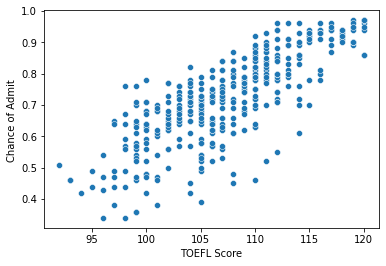

In [46]:
# For TOEFL Scores
sns.scatterplot(x=dataset['TOEFL Score'], y=dataset['Chance of Admit '])
plt.show()

Just like the GRE Scores, higher the TOEFL Scores better are the chances of Admission.

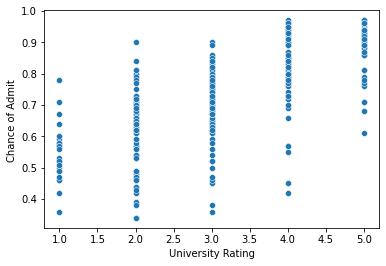

In [47]:
# For Univeristy Rating
sns.scatterplot(x=dataset['University Rating'], y=dataset['Chance of Admit '])
plt.show()

Although Univeristy Rating does not seem to be of distinguishing contribution, but University Rating > 3 have a comparitive higher chances of Admission.

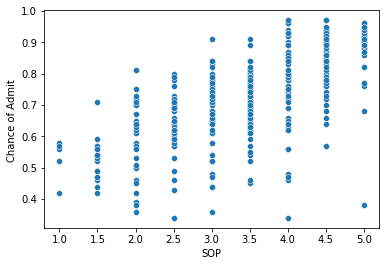

In [48]:
# For SOP Strength
sns.scatterplot(x=dataset['SOP'], y=dataset['Chance of Admit '])
plt.show()

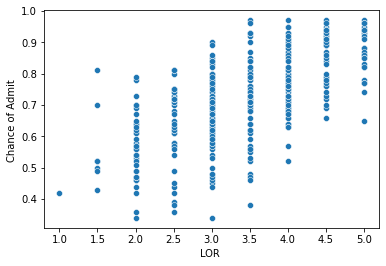

In [49]:
# For LOR Strength
sns.scatterplot(x=dataset['LOR '], y=dataset['Chance of Admit '])
plt.show()

Both the SOP and LOR Strength have similar kind of trends where they show that the higher they are the better are the chances of admission. SOP and LOR > 3 have almost similar kind of chances of admission.

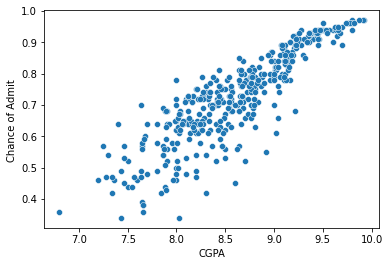

In [50]:
# For CGPA
sns.scatterplot(x=dataset['CGPA'], y=dataset['Chance of Admit '])
plt.show()

Higher CGPA increases the chances of admission.

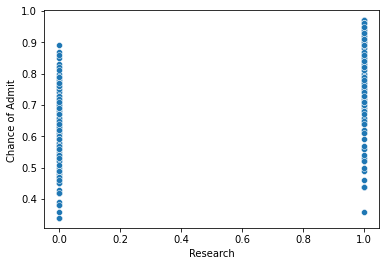

In [52]:
# For Research
sns.scatterplot(x=dataset['Research'], y=dataset['Chance of Admit '])
plt.show()

The Research Factor is not much differentiating with those people who have done research having slightly higher chances of admission.

<h2>Prediction</h2>

The Implementation of KFold and Linear Regression with both the losses i.e. RMSE and MAE is done from scratch.

In [4]:
# Creating the features and target numpy arrays
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

# Initializing the Validation Curve Plotting Class
validationCurve = ValidationCurve()

<h3>For RMSE Loss Gradient Descent</h3>


For fold => 1
=> Training loss => 0.1121979013521193
=> Validation loss => 0.15323994476120786

For fold => 2
=> Training loss => 0.11750906454455276
=> Validation loss => 0.13448530906090872

For fold => 3
=> Training loss => 0.12594021612646203
=> Validation loss => 0.10226502349444563

For fold => 4
=> Training loss => 0.1284772977882307
=> Validation loss => 0.08540064875348073

For fold => 5
=> Training loss => 0.11960004591860113
=> Validation loss => 0.12710445137319626


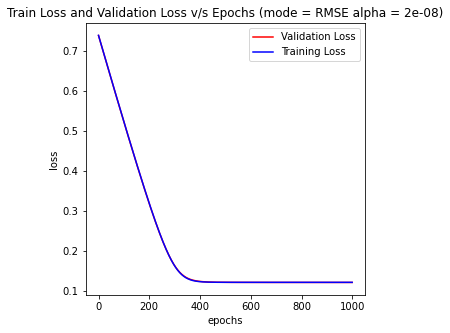

In [54]:
validationCurve.plot_curve(5,x,y,"RMSE",2e-8,1000)

<ul>
<li>Number of Folds = 5</li>
<li>Epochs = 1000</li>
<li>Alpha = 2e-8</li>
<li>Mode of Gradient Descent = Root Mean Square Error</li>
</ul>
Fold 4 shows the best value of Validation Loss (0.08540064875348073)

<h3>For MAE Loss Gradient Descent</h3>


For fold => 1
=> Training loss => 0.0873041067324944
=> Validation loss => 0.12967444779033796

For fold => 2
=> Training loss => 0.09211412525328337
=> Validation loss => 0.11002698827812259

For fold => 3
=> Training loss => 0.10052646726309362
=> Validation loss => 0.07768954068282696

For fold => 4
=> Training loss => 0.10243042771244433
=> Validation loss => 0.06877588998619706

For fold => 5
=> Training loss => 0.09568352139282844
=> Validation loss => 0.09565994050020138


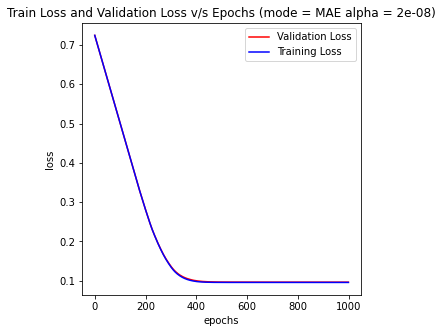

In [55]:
validationCurve.plot_curve(5,x,y,"MAE",2e-8,1000)

<ul>
<li>Number of Folds = 5</li>
<li>Epochs = 1000</li>
<li>Alpha = 2e-8</li>
<li>Mode of Gradient Descent = Mean Average Error</li>
</ul>
Fold 4 shows the best value of Validation Loss (0.06877588998619706)

The MAE error and RMSE error provide similar values(MAE slightly lower) indicating that the dataset does not much variation and outliers. This was also confirmed during Exploratory Data Analysis.

<h3> Comparison with Sklearn's Linear Regression</h3>

In [57]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.2,random_state = 1)
sk_linear_reg = SGDRegressor(learning_rate='constant',eta0 = 2e-8,max_iter=1000)
sk_linear_reg.fit(x_train, y_train)
print("Training Loss ==> "+str(sk_linear_reg.score(x_train, y_train)))
print("Validation Loss ==> "+str(sk_linear_reg.score(x_val, y_val)))

Training Loss ==> 0.27723876647008006
Validation Loss ==> 0.27376272846598626


Our model which has been implemented from scratch outperforms the SKlearn's implementation with the same set of hyperparameters

<h3>Saving the model</h3>

In [5]:
fin_model = LinearRegression()
fin_model.fit(x,y)
joblib.dump(fin_model,'./Model/fin_model.pkl')
print("Model Saved")

Model Saved
